# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Project Intro:

Megaline telecommunication company offers its clients two prepaid plans, Surf and Ultimate.  I'll conduct a comparative analysis of the plans based on the data from 500 Megaline clients natinwide to establish which plan brings in more revenue for the purposes of adusting the company's advertizing strategies and budget.  Among the client data is information about who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018.  Using the data from five csv files (megaline_calls.csv, megaline_internet.csv, megaline_messages.csv, megaline_plans.csv, megaline_users.csv) I'll utilize the usage data and plan conditions to calculate the company's monthly revenue for each user in their respective plans, and then analyze user behavior month-over-month to establish whether revenue significantly differs between the plans.

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd 
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st

## Load data

In [2]:
calls = pd.read_csv('/datasets/megaline_calls.csv')# Load the data files into different DataFrames

In [3]:
internet = pd.read_csv('/datasets/megaline_internet.csv')

In [4]:
messages = pd.read_csv('/datasets/megaline_messages.csv')

In [5]:
plans = pd.read_csv('/datasets/megaline_plans.csv')

In [6]:
users = pd.read_csv('/datasets/megaline_users.csv')

## Prepare the data

## Plans

In [7]:
# Print the general/summary information about the plans' DataFrame
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [8]:
# Print a sample of data for plans
plans



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


I will convert 'mb_per_month_included' to 'gb_per_month_included' and drop the decimal, since the total number of megabytes for the month is rounded up to gigabytes regardless of actual total usage.

## Fix data

In [9]:
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024
plans['gb_per_month_included'] = plans['gb_per_month_included'].astype('int64')
plans.drop('mb_per_month_included', axis=1, inplace=True)
plans.rename(columns={'plan_name': 'plan'}, inplace=True)
plans

,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan,gb_per_month_included
0,50,500,20,10,0.03,0.03,surf,15
1,1000,3000,70,7,0.01,0.01,ultimate,30


## Users

In [10]:
# Print the general/summary information about the users' DataFrame
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [11]:
# Print a sample of data for users
users.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
288,1288,Jenette,Rush,60,"Las Vegas-Henderson-Paradise, NV MSA",2018-07-18,surf,NaN
346,1346,Emmie,Gonzalez,59,"Tucson, AZ MSA",2018-04-26,ultimate,NaN
321,1321,Karlyn,Jimenez,19,"North Port-Sarasota-Bradenton, FL MSA",2018-05-31,surf,NaN
464,1464,Burt,Burke,70,"Providence-Warwick, RI-MA MSA",2018-11-07,surf,NaN
488,1488,Shirley,Jones,29,"Baton Rouge, LA MSA",2018-05-15,surf,NaN
436,1436,Jennine,Kinney,69,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-08-26,ultimate,NaN
439,1439,Moses,Cabrera,28,"Riverside-San Bernardino-Ontario, CA MSA",2018-01-04,surf,NaN
164,1164,Kam,Macias,31,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-02-17,ultimate,NaN
180,1180,Wonda,Hays,24,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-12-01,surf,2018-12-22
483,1483,Miguel,Farrell,35,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-04-25,surf,NaN


I will convert the 'reg_date' and 'churn_date' types from object to a datetime format to make it easier to analyze monthly usage later on.

### Fix Data

In [12]:
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])
users['churn_date'].fillna('active', inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


## Calls

In [13]:
# Print the general/summary information about the calls' DataFrame
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [14]:
# Print a sample of data for calls
calls.sample(10)



,id,user_id,call_date,duration
27802,1106_60,1106,2018-06-19,4.42
101072,1361_174,1361,2018-09-09,13.18
125400,1443_62,1443,2018-11-25,0.54
28377,1109_4,1109,2018-08-31,0.00
38135,1144_14,1144,2018-06-28,6.09
68178,1246_197,1246,2018-02-24,13.35
66314,1240_172,1240,2018-11-01,3.73
123762,1436_727,1436,2018-12-10,4.62
120246,1418_130,1418,2018-12-13,6.98
130674,1470_123,1470,2018-10-13,0.00


I will remove the underscore in 'id' and change the data type to int64.  I will also change the 'call_date' type to datetime64 to make monthly analysis easier later on. Once the data is aggregated monthly, we can round it up to the nearest minute and convert the data to int64.

### Fix data

In [15]:
calls['id'] = calls['id'].replace('_', '').astype('int64')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

## Messages

In [16]:
# Print the general/summary information about the messages' DataFrame
messages.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [17]:
# Print a sample of data for messages
messages.sample(10)



,id,user_id,message_date
67459,1438_25,1438,2018-12-06
49174,1328_132,1328,2018-10-28
66276,1433_216,1433,2018-11-21
70148,1456_15,1456,2018-09-06
44219,1294_0,1294,2018-10-27
75207,1489_282,1489,2018-09-12
10263,1076_607,1076,2018-12-08
59296,1374_470,1374,2018-09-11
27338,1167_295,1167,2018-08-24
12792,1084_32,1084,2018-11-24


As above I will change the 'message_date' type to datetime64 to make monthly analysis easier later on and fix the 'id' column.

### Fix data

In [18]:
messages['id'] = messages['id'].replace('_', '').astype('int64')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')


## Internet

In [19]:
# Print the general/summary information about the internet DataFrame
internet.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [20]:
# Print a sample of data for the internet traffic
internet.sample(10)



,id,user_id,session_date,mb_used
98878,1467_15,1467,2018-06-24,305.55
25672,1120_197,1120,2018-04-06,0.00
88471,1408_190,1408,2018-05-14,253.20
35003,1157_90,1157,2018-11-18,423.97
27281,1126_407,1126,2018-11-30,410.14
96809,1456_51,1456,2018-11-02,491.76
12792,1061_289,1061,2018-05-03,144.16
2739,1013_69,1013,2018-12-23,330.89
91907,1426_1,1426,2018-12-28,539.85
48448,1215_170,1215,2018-10-20,0.00


Again, I will change the 'message_date' type to datetime64 to make monthly analysis easier later on, and address the 'id' column. Once the data is aggregated monthly, I will convert and replace the 'mb_used' column to 'gb_used'.

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [21]:
internet['id'] = internet['id'].replace('_', '').astype('int64')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

## Study plan conditions

I print the 'plans' dataframe again to clearly view the conditions once again before Aggregating the data.

In [22]:
plans


,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan,gb_per_month_included
0,50,500,20,10,0.03,0.03,surf,15
1,1000,3000,70,7,0.01,0.01,ultimate,30


## Aggregate data per user

I will group the 'calls', 'minutes', 'messages', and 'internet' DataFrames by month and user id to get the monthly call count for each user.  Additionally, I will convert and address the month by name moving forward on each subsequent DataFrame.

In [23]:
monthly_calls = calls.groupby([calls['call_date'].dt.strftime('%B'), 'user_id']).size().reset_index()# Calculate the number of calls made by each user per month. Save the result.
monthly_calls.rename(columns={'call_date': 'month', 0: 'call_count'}, inplace=True)
monthly_calls

,month,user_id,call_count
0,April,1010,90
1,April,1028,7
2,April,1041,60
3,April,1042,44
4,April,1049,30
...,...,...,...
2253,September,1494,67
2254,September,1495,52
2255,September,1496,52
2256,September,1498,45


In [24]:
monthly_minutes = calls.groupby([calls['call_date'].dt.strftime('%B'), 'user_id'])['duration'].sum().reset_index() # Calculate the amount of minutes spent by each user per month. Save the result.
monthly_minutes.rename(columns={'call_date': 'month', 'duration': 'minutes_per_month'}, inplace=True) 
monthly_minutes['minutes_per_month'] = monthly_minutes['minutes_per_month'].apply(np.ceil)
monthly_minutes

,month,user_id,minutes_per_month
0,April,1010,619.0
1,April,1028,50.0
2,April,1041,425.0
3,April,1042,265.0
4,April,1049,225.0
...,...,...,...
2253,September,1494,460.0
2254,September,1495,284.0
2255,September,1496,390.0
2256,September,1498,345.0


In [25]:
monthly_messages = messages.groupby([messages['message_date'].dt.strftime('%B'), 'user_id']).size().reset_index()# Calculate the number of messages sent by each user per month. Save the result.
monthly_messages.rename(columns={'message_date': 'month', 0: 'message_count'}, inplace=True)
monthly_messages

,month,user_id,message_count
0,April,1028,77
1,April,1054,6
2,April,1059,20
3,April,1061,17
4,April,1062,5
...,...,...,...
1801,September,1489,59
1802,September,1491,50
1803,September,1492,11
1804,September,1494,21


I will convert the 'mb_sum' here to 'gb_sum' to better align with plan conditions.

In [26]:
monthly_traffic = internet.groupby([internet['session_date'].dt.strftime('%B'), 'user_id'])['mb_used'].sum().reset_index()# Calculate the volume of internet traffic used by each user per month. Save the result.
monthly_traffic.rename(columns={'session_date': 'month', 'mb_used': 'mb_sum'}, inplace=True)
monthly_traffic['gb_sum'] = monthly_traffic['mb_sum'] / 1000
monthly_traffic['gb_sum'] = np.ceil(monthly_traffic['gb_sum']).astype('int64')
monthly_traffic

,month,user_id,mb_sum,gb_sum
0,April,1010,19722.34,20
1,April,1028,37761.59,38
2,April,1041,20601.58,21
3,April,1042,7102.40,8
4,April,1049,5374.00,6
...,...,...,...,...
2272,September,1494,16181.14,17
2273,September,1495,22981.37,23
2274,September,1496,16389.27,17
2275,September,1498,22827.28,23


I will merge each smaller DataFrame into one DataFrame, so that one record in it will represent what a unique user consumed in a given month.

In [27]:
usage_merged = pd.merge(monthly_calls, monthly_minutes, on=['month', 'user_id'], how='outer').merge(monthly_messages, on=['month', 'user_id'], how='outer').merge(monthly_traffic, on=['month', 'user_id'], how='outer')# Merge the data for calls, minutes, messages, internet based on user_id and month
usage_merged = usage_merged.sort_values(by='month').reset_index(drop=True)
usage_merged

,month,user_id,call_count,minutes_per_month,message_count,mb_sum,gb_sum
0,April,1010,90.0,619.0,NaN,19722.34,20.0
1,April,1334,104.0,753.0,14.0,15474.76,16.0
2,April,1328,19.0,117.0,21.0,2749.33,3.0
3,April,1324,129.0,992.0,120.0,14162.32,15.0
4,April,1320,71.0,423.0,27.0,8356.98,9.0
...,...,...,...,...,...,...,...
2288,September,1181,89.0,605.0,30.0,19238.08,20.0
2289,September,1179,64.0,437.0,21.0,13842.13,14.0
2290,September,1174,87.0,665.0,66.0,16506.98,17.0
2291,September,1189,13.0,115.0,6.0,4255.45,5.0


In [28]:
users_merged = pd.merge(usage_merged, users, on='user_id', how='outer')# Add the plan information
users_plan = pd.merge(users_merged, plans, on='plan', how='outer')
users_plan.drop('mb_sum', axis=1, inplace=True)
users_plan.fillna(0, inplace=True)
users_plan = users_plan.astype({'call_count': 'int64', 'minutes_per_month': 'int64', 'message_count': 'int64', 'gb_sum': 'int64'})
pd.set_option('display.max_columns', None)
users_plan.head()

,month,user_id,call_count,minutes_per_month,message_count,gb_sum,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
0,April,1010,90,619,0,20,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15
1,August,1010,93,599,0,20,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15
2,July,1010,101,659,0,13,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15
3,June,1010,77,525,0,17,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15
4,March,1010,63,409,0,11,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15


I will call nunique on the newly aggregated 'users_plan' DataFrame for each plan, to see how many users subscribe to each plan.

In [29]:
users_plan[users_plan['plan'] == 'surf']['user_id'].nunique()

339

In [30]:
users_plan[users_plan['plan'] == 'ultimate']['user_id'].nunique()

161

I will use this 'calc_revenue' function to calculate the monthly revenue from each user by subtracting the free package limit from the total number of calls/text messages/data, then multiply the result by the calling plan value and finally, add the monthly charge depending on the calling plan. I will then add the resulting values to a new column called 'user_monthly_rev'.

In [31]:
# Calculate the monthly revenue for each user
def calc_revenue(row):

    rev = 0
    
    plan_name = row['plan']
    call_min = row['minutes_per_month']
    message_count = row['message_count']
    gb_sum = row['gb_sum']
    
    # Difference from the included plan
    
    min_exceeded = call_min - row['minutes_included']
    
    msg_exceeded = message_count - row['messages_included']
    
    gb_exceeded = gb_sum - row['gb_per_month_included']
    
    # rev if user went over limit
    if min_exceeded > 0:
        rev += min_exceeded * row['usd_per_minute']
    if msg_exceeded > 0:
        rev += msg_exceeded * row['usd_per_message']
    if gb_exceeded > 0:
        rev += gb_exceeded * row['usd_per_gb']
    
    # summing up all the charges
    rev += row['usd_monthly_pay']
    
    return rev

users_plan['user_monthly_rev'] = users_plan.apply(calc_revenue, axis=1)
pd.set_option('display.max_columns', None)
users_plan.head(10)

,month,user_id,call_count,minutes_per_month,message_count,gb_sum,first_name,last_name,age,city,reg_date,plan,churn_date,messages_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,user_monthly_rev
0,April,1010,90,619,0,20,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15,73.57
1,August,1010,93,599,0,20,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15,72.97
2,July,1010,101,659,0,13,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15,24.77
3,June,1010,77,525,0,17,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15,40.75
4,March,1010,63,409,0,11,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15,20.00
5,May,1010,81,498,0,16,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15,30.00
6,November,1010,30,246,0,8,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15,20.00
7,October,1010,95,669,0,17,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15,45.07
8,September,1010,83,569,0,17,Wilber,Blair,52,"Dallas-Fort Worth-Arlington, TX MSA",2018-03-09,surf,active,50,500,20,10,0.03,0.03,15,42.07
9,April,1334,104,753,14,16,Donovan,Horton,34,"Seattle-Tacoma-Bellevue, WA MSA",2018-03-08,surf,active,50,500,20,10,0.03,0.03,15,37.59


## Study user behaviour

Here, I'll calculate, caputure, and compare user behavior, as well as develop some useful descriptive statistics for the aggregated and merged data. I'll will apply a series of bar and box charts to help visualize the analysis, and help draw some meaningful insight from the data based on the plans. The result should help shine a light on which one is more profitable.

### Calls

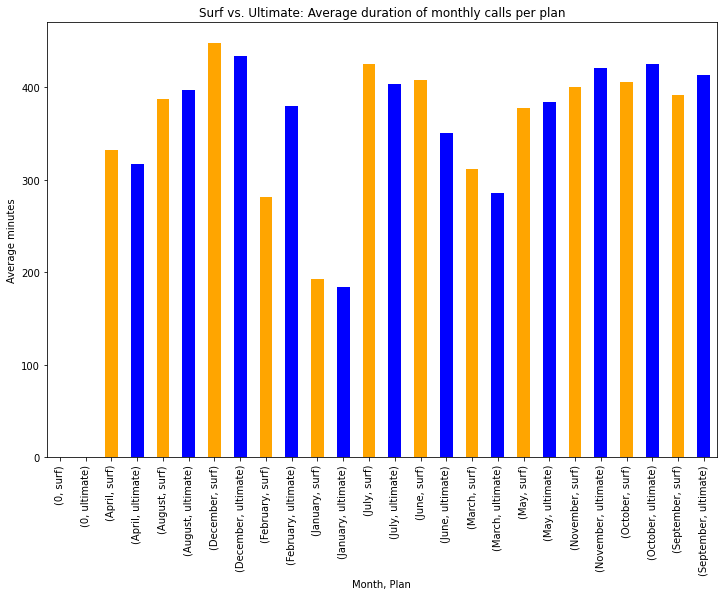

In [32]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plot to visualize it.
(users_plan.groupby(['month', 'plan'])['minutes_per_month'].mean().T.plot(kind='bar', color=('orange', 'blue'), figsize=(12, 8)))
plt.title('Surf vs. Ultimate: Average duration of monthly calls per plan')
plt.xlabel('Month, Plan')
plt.ylabel('Average minutes')
plt.show()

In [33]:
# Compare total minutes used per month:
sum_monthly_min = users_plan.groupby(['plan', 'month'])['minutes_per_month'].sum().reset_index()

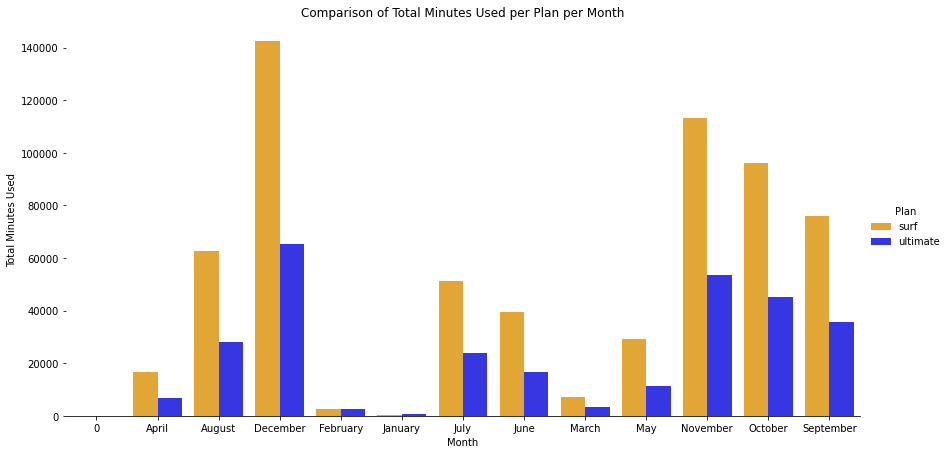

In [34]:
g = sns.catplot(
    data=sum_monthly_min, kind="bar",
    x="month", y="minutes_per_month", hue="plan",
    ci=None, palette=sns.color_palette(['orange', 'blue']), alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Month", "Total Minutes Used")
g.legend.set_title("Plan")
plt.title("Comparison of Total Minutes Used per Plan per Month")
plt.show()

In [35]:
# Calculate the mean and the variance of the monthly call duration
monthly_calls = calls.groupby(['user_id', calls['call_date'].dt.strftime('%B')]).agg(total_calls=('duration', 'count'), total_duration=('duration', 'sum')).reset_index()
# Duration Mean & Variance:                                
duration_mean = monthly_calls['total_duration'].mean()
duration_variance = monthly_calls['total_duration'].var()
# Call Mean & Variance:
call_mean = monthly_calls['total_calls'].mean()
call_variance = monthly_calls['total_calls'].var()

print("Monthly Call duration mean:", duration_mean)
print("Monthly Call duration variance:", duration_variance)  
print()
print("Mean of total calls per month:", call_mean)
print("Variance of total calls per month", call_variance)

Monthly Call duration mean: 411.4925863596103
Monthly Call duration variance: 48088.30262015758

Mean of total calls per month: 60.99867139061116
Variance of total calls per month 1009.3881240647639


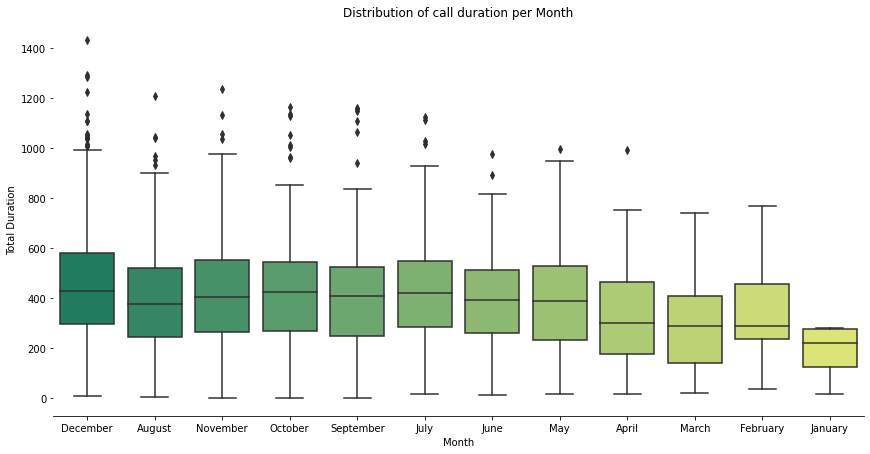

In [36]:
# Plot a boxplot to visualize the distribution of the monthly call duration

g = sns.catplot(
    data=monthly_calls, kind="box",
    x="call_date", y="total_duration",
    ci=None, palette='summer', height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Month", "Total Duration")
plt.title("Distribution of call duration per Month")
plt.show()



__The overall average call duration tracks fairly evenly across all months for both plans, except for in February, where call durations separate with ultimate users having a longer average call duration.__  

__At the same time, surf users clearly use more total minutes per month. Again however, except in February, and in January where total usage is low and fairly even among both plans. A contributing factor to higher total minutes could be the fact that the surf plan has more than double the amount of users in the sample group.__

__December and November have the largest call volume overall, which may be expected as populations tend to connect more over the holiday season.  Right afterward, January and February recorded the lowest overall call volume across all months.__

### Messages

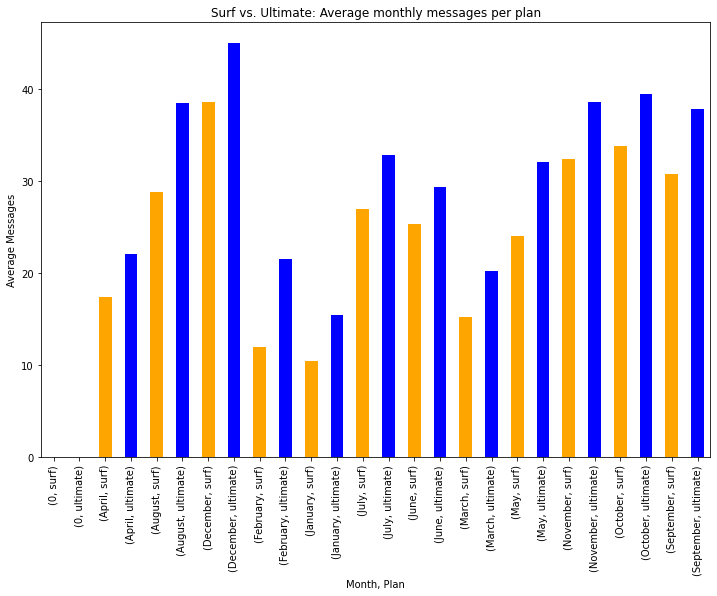

In [37]:
# Compare the number of messages users of each plan tend to send each month. Plot a bar plot to visualize it.
(users_plan.groupby(['month', 'plan'])['message_count'].mean().T.plot(kind='bar', color=('orange', 'blue'), figsize=(12, 8)))
plt.title('Surf vs. Ultimate: Average monthly messages per plan')
plt.xlabel('Month, Plan')
plt.ylabel('Average Messages')
plt.show()


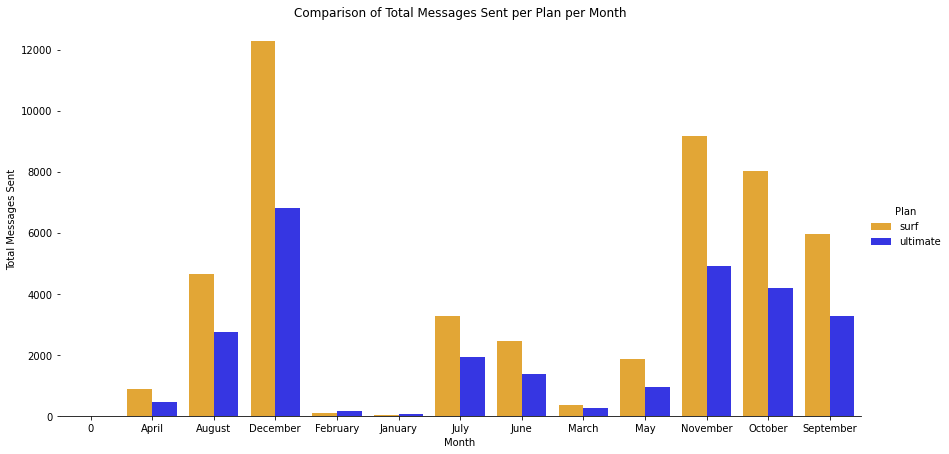

In [38]:
# Compare total messages sent per month:
sum_monthly_messages = users_plan.groupby(['plan', 'month'])['message_count'].sum().reset_index()

g = sns.catplot(
    data=sum_monthly_messages, kind="bar",
    x="month", y="message_count", hue="plan",
    ci=None, palette=sns.color_palette(['orange', 'blue']), alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Month", "Total Messages Sent")
g.legend.set_title("Plan")
plt.title("Comparison of Total Messages Sent per Plan per Month")
plt.show()

In [39]:
# Calculate the mean and the variance of the monthly messages sent
total_monthly_messages = monthly_messages.groupby(['user_id', 'month']).agg(total_messages=('message_count', 'sum')).reset_index()
# Mean & Variance:                                
message_mean = total_monthly_messages['total_messages'].mean()
message_variance = total_monthly_messages['total_messages'].var()

print("Mean of total monthly messages sent:", message_mean) 
print("Variance of total monthly messages:", message_variance)            

Mean of total monthly messages sent: 42.110188261351055
Variance of total monthly messages: 1097.1285720421004


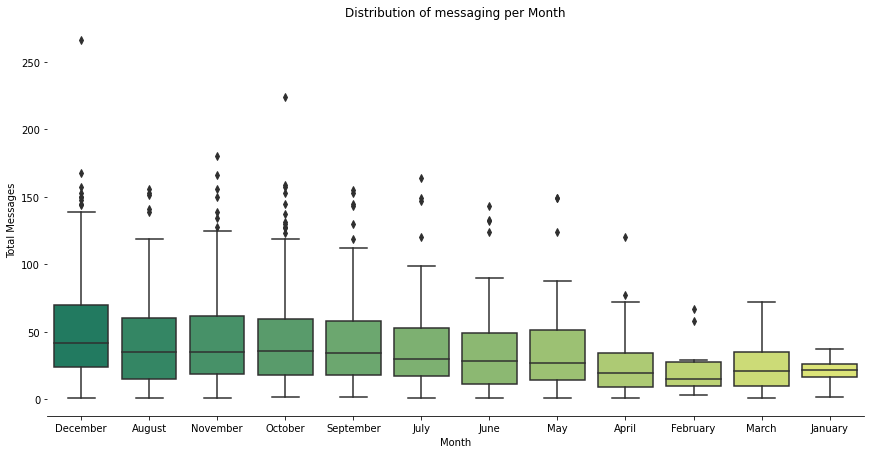

In [40]:
# Plot a boxplot to visualize the distribution of the total monthly messages
g = sns.catplot(
    data=total_monthly_messages, kind="box",
    x="month", y="total_messages",
    ci=None, palette='summer', height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Month", "Total Messages")
plt.title("Distribution of messaging per Month")
plt.show()


Ultimate users have the higher average amount of monthly messages across all months. The communication pattern seen in the call charts holds here as well, with December seeing the largest average volume of messages sent among both plans.

Again, surf users dominate the total messages sent per month, except in February and January. Similarly, the larger amount of users could be a contributing factor here too.

December and November continue to have the largest overall message volume, with January and February recording the least. There are some clear outliers to note among the users, which could be a factor pulling averages.

### Internet

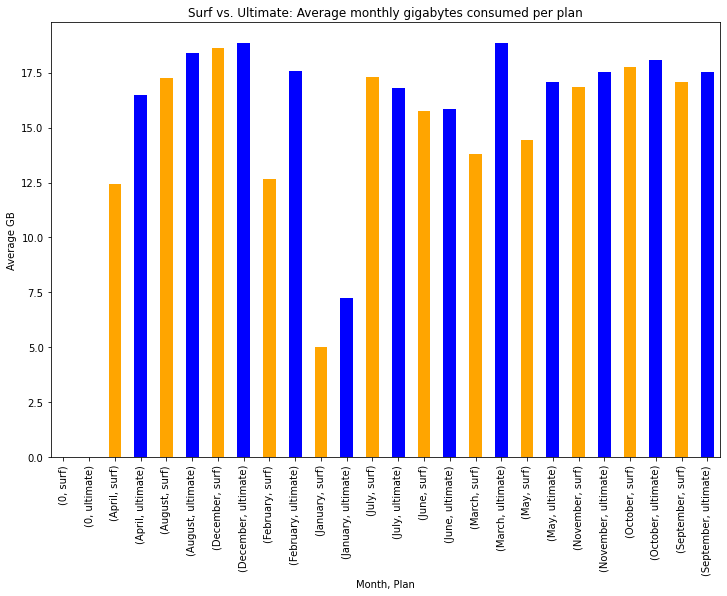

In [41]:
# Compare the average amount of internet traffic consumed by users per plan
(users_plan.groupby(['month', 'plan'])['gb_sum'].mean().T.plot(kind='bar', color=('orange', 'blue'), figsize=(12, 8)))
plt.title('Surf vs. Ultimate: Average monthly gigabytes consumed per plan')
plt.xlabel('Month, Plan')
plt.ylabel('Average GB')
plt.show()



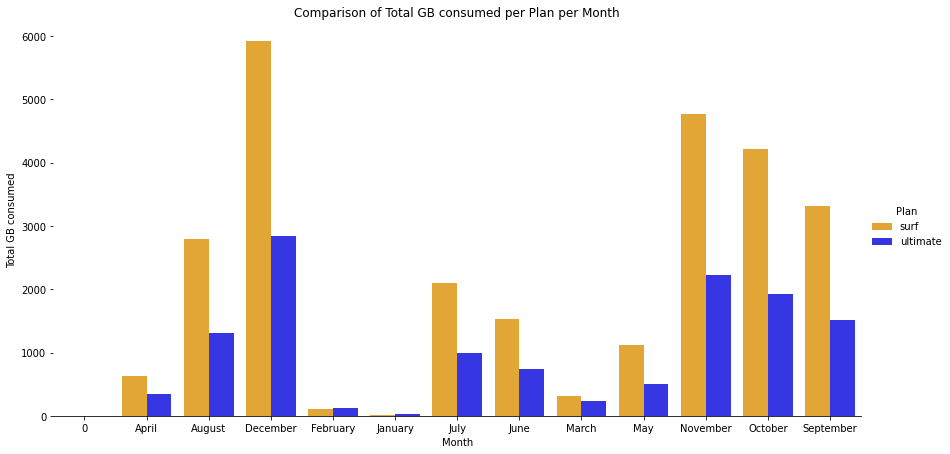

In [42]:
# Compare total GB consumed per month by users of each plan:
sum_monthly_gb_used = users_plan.groupby(['plan', 'month'])['gb_sum'].sum().reset_index()

g = sns.catplot(
    data=sum_monthly_gb_used, kind="bar",
    x="month", y="gb_sum", hue="plan",
    ci=None, palette=sns.color_palette(['orange', 'blue']), alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Month", "Total GB consumed")
g.legend.set_title("Plan")
plt.title("Comparison of Total GB consumed per Plan per Month")
plt.show()

In [43]:
# Calculate the mean and the variance of the monthly messages sent
total_monthly_gb = monthly_traffic.groupby(['user_id', 'month']).agg(total_gb=('gb_sum', 'sum')).reset_index()
# Mean & Variance:                                
gb_mean = total_monthly_gb['total_gb'].mean()
gb_variance = total_monthly_gb['total_gb'].var()

print("Mean of total monthly GB consumed:", gb_mean) 
print("Variance of total monthly GB consumed:", gb_variance) 

Mean of total monthly GB consumed: 17.372859025032938
Variance of total monthly GB consumed: 61.92198712115424


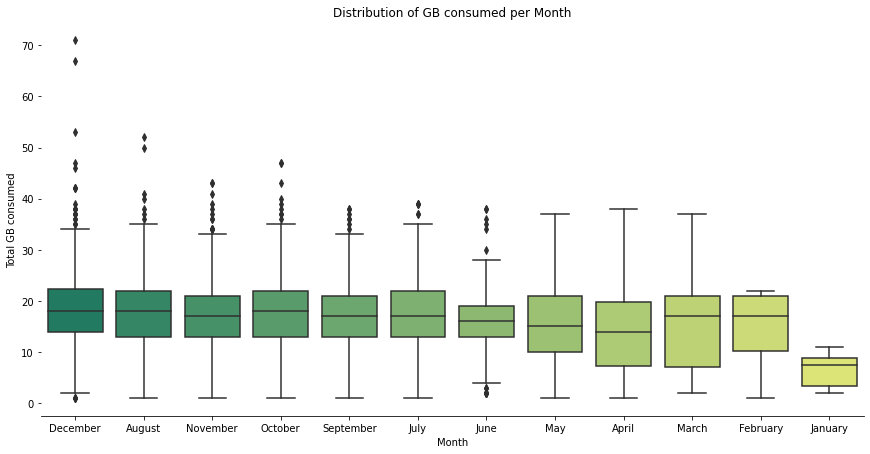

In [44]:
# Plot a boxplot to visualize the distribution of the total monthly GB consumed
g = sns.catplot(
    data=total_monthly_gb, kind="box",
    x="month", y="total_gb",
    ci=None, palette='summer', height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Month", "Total GB consumed")
plt.title("Distribution of GB consumed per Month")
plt.show()

Average GB usage tracks fairly evenly across most months with the exception of April, February, and March, where Ultimate users' average consumption is noticably higher. The monthy usages pattern continues reliably.

Once again, surf users dominate the total GB usage, where volume from both plans is low. likewise, the larger amount of users could be a contributing factor here too.

December and November continue to have the largest overall usage volume, with January and February recording the least. Here too, there are some clear outliers to note, especially in December, which could be a factor pulling averages.

## Revenue

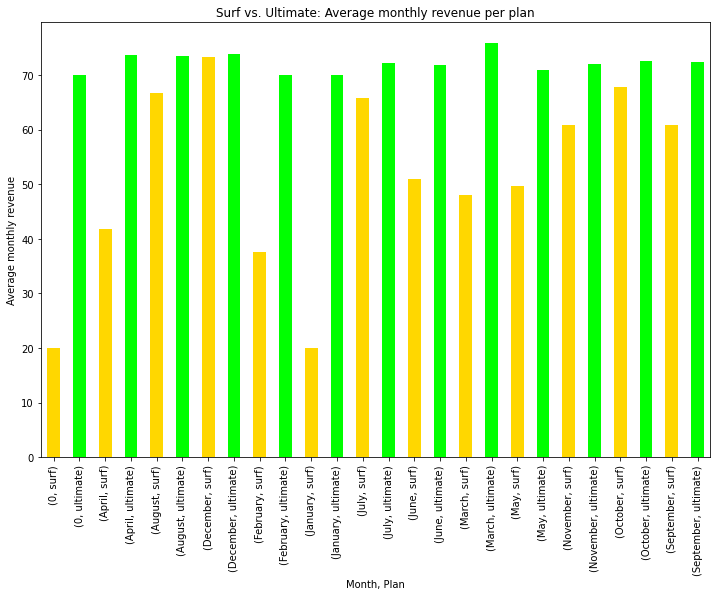

In [45]:
# Compare the average monthly revenue per plan:
(users_plan.groupby(['month', 'plan'])['user_monthly_rev'].mean().T.plot(kind='bar', color=('gold', 'lime'), figsize=(12, 8)))
plt.title('Surf vs. Ultimate: Average monthly revenue per plan')
plt.xlabel('Month, Plan')
plt.ylabel('Average monthly revenue')
plt.show()

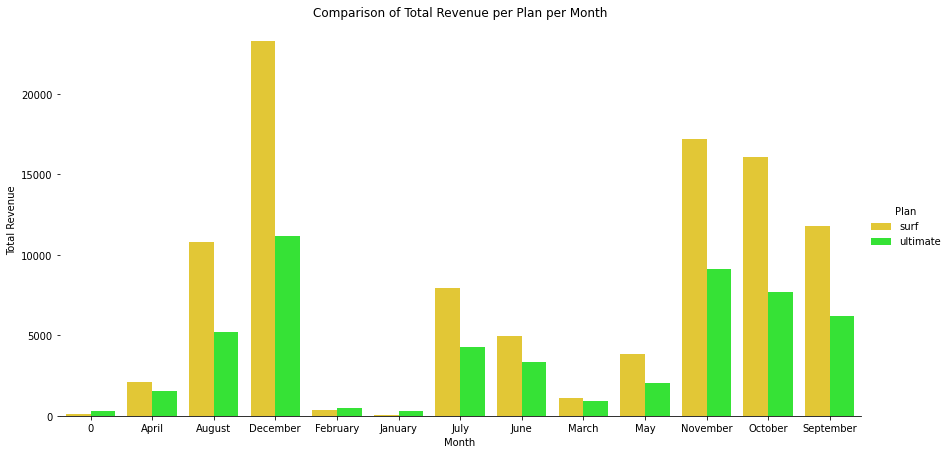

In [46]:
# Compare total monthly revenue by users of each plan:
sum_monthly_rev = users_plan.groupby(['plan', 'month'])['user_monthly_rev'].sum().reset_index()

g = sns.catplot(
    data=sum_monthly_rev, kind="bar",
    x="month", y="user_monthly_rev", hue="plan",
    ci=None, palette=sns.color_palette(['gold', 'lime']), alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Month", "Total Revenue")
g.legend.set_title("Plan")
plt.title("Comparison of Total Revenue per Plan per Month")
plt.show()

In [47]:
# Calculate the mean and the variance of the monthly messages sent
total_monthly_rev = users_plan.groupby(['user_id', 'month']).agg(total_rev=('user_monthly_rev', 'sum')).reset_index()
# Mean & Variance:                                
total_rev_mean = total_monthly_rev['total_rev'].mean()
total_rev_variance = total_monthly_rev['total_rev'].var()

print("Total revenue mean:", total_rev_mean) 
print("Total revenue variance:", total_rev_variance)

Total revenue mean: 66.09558402084238
Total revenue variance: 2315.7521244089885


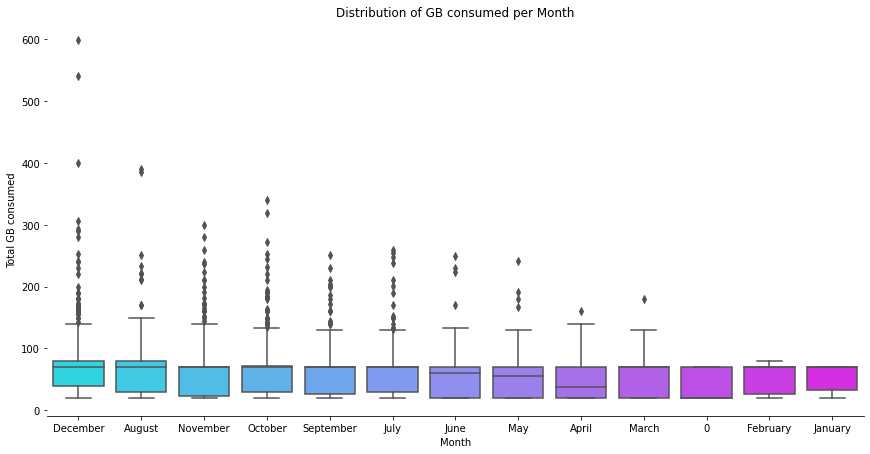

In [48]:
# Plot a boxplot to visualize the distribution of the total monthly GB consumed
g = sns.catplot(
    data=total_monthly_rev, kind="box",
    x="month", y="total_rev",
    ci=None, palette='cool', height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Month", "Total GB consumed")
plt.title("Distribution of GB consumed per Month")
plt.show()

__The average monthly revenue from surf users shows that more of them exceed the plan base cost than those using the ultimate plan. However, the ultimate users show a higher average monthly revenue across all months.  The higher base cost of the ultimate plan may make up for having less users than the less expensive surf plan.  I expect that there is little difference in revenue between the two plans due to mainly to this.__

__In order to test this hypothesis, I will statistically compare the average revenue generated among both plans to see if they if they differ outside a 5% margin of each other.__

## Test statistical hypotheses

### Surf vs. Ultimate: Does average revenue differ?

__Null & Alternative Hypotheses:__

__H0__ : _The average revenue from users of the Ultimate and Surf calling plans do not differ_

__H1__ : _The average revenue from users of the Ultimate and Surf calling plans differ_

In [49]:
# Test the hypotheses
surf_sample = users_plan[users_plan['plan'] == 'surf']['user_monthly_rev']
ultimate_sample = users_plan[users_plan['plan'] == 'ultimate']['user_monthly_rev']

results = st.ttest_ind(surf_sample, ultimate_sample)
alpha = 0.05

if results.pvalue > alpha:
    print("Reject H0")
else:
    print("Can't Reject H0")
print()
print("p-value =", results.pvalue)

Can't Reject H0

p-value = 8.205703388152599e-06


### NY-NJ Average Revenue vs. The rest of the country

__Null & Alternative Hypotheses:__

__H0__ : _The average revenue from users in the NY-NJ area does not differ from the rest of the country_

__H1__ : _The average revenue from users in the NY-NJ area differs from the rest of the country_

In [50]:
# Test the hypotheses
ny_nj_sample = users_plan[users_plan['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['user_monthly_rev']
other_regions_sample = users_plan[users_plan['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['user_monthly_rev']
results = st.ttest_ind(ny_nj_sample, other_regions_sample) 
alpha = 0.05

if results.pvalue > alpha:
    print("Reject H0")
else:
    print("Can't reject H0")
print()
print("p-value =", results.pvalue)


Reject H0

p-value = 0.10581023634857656


## General conclusion

The assumption based on all the call, message, internet, and revenue data was that there was little difference in revenue between the two plans. That assumption is statistically affirmed to within a 5% margin of error. Thus, we can reject the null hypothesis that the average revenue between the two plans differs.  However, regionally we can't confidently assert that revenue does not differ from the region to region.  It may be more lucrative to conentrate marketing resources regionally, than nationwide by plan

Running this analysis in multitude with more individual, large random sample groups from both plans will assist to further identify any meaningful differences in revenue across plans and regions to a higher degree of certainty.  Furthermore, it could be insightful to localize the individual sample groups amongst clustered geographical regions in order to help confidently assess where to target marketing. 